In [1]:
import torch
import os
from PIL import Image
from model import UNetGenerator, get_norm_layer
from torchvision import transforms
from dataset import makeDataset
import pickle
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def normalize(tensor,zero2one=False):
    shape=tensor.shape
    tensor_norm=tensor.reshape([shape[0],shape[1],-1])
    tensor_max=tensor_norm.max(dim=-1,keepdim=True)[0]
    tensor_min=tensor_norm.min(dim=-1,keepdim=True)[0]
    tensor_norm=((tensor_norm-tensor_min)/(tensor_max-tensor_min))
    if zero2one:
        tensor_norm=tensor_norm.reshape(shape)
    else:
        tensor_norm=((tensor_norm-0.5)*2.0).reshape(shape)
    return tensor_norm

In [3]:
ngf=64
use_droplayer=False
norm_type='batch'
norm_layer=get_norm_layer(norm_type)
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
unet=UNetGenerator(in_c=1,out_c=1,ngf=ngf,norm_layer=norm_layer,use_drop=use_droplayer)
unet.to(DEVICE)
cycleGAN=UNetGenerator(in_c=1,out_c=1,ngf=ngf,norm_layer=norm_layer,use_drop=use_droplayer)
cycleGAN.to(DEVICE)
if torch.cuda.device_count()>1:
    print("Available GPUs {}".format(torch.cuda.device_count()))
    unet=torch.nn.DataParallel(unet)
    
if torch.cuda.is_available():
    print('CUDA Available!')
    unet.load_state_dict(torch.load('./final_result_denoising_unet/denoising_unet.pt'))
    cycleGAN.load_state_dict(torch.load('./final_result/GAN_QD_to_FD/GAN.pt'))
else:
    print('CUDA is unavailable, using CPU instead!')
    unet.load_state_dict(torch.load('./final_result_denoising_unet/denoising_unet.pt', map_location=torch.device('cpu')))
    cycleGAN.load_state_dict(torch.load('./final_result/GAN_QD_to_FD/GAN.pt', map_location=torch.device('cpu')))

CUDA Available!


In [5]:
psnr=PeakSignalNoiseRatio(data_range=1,dim=[-1,-2,-3])
psnr_=PeakSignalNoiseRatio(data_range=1)
ssim=StructuralSimilarityIndexMeasure()
centerCrop=transforms.CenterCrop(350)
pred_imgs=[]
pred_imgs_cycleGAN=[]
pred_imgs_unNormal=[]
totalPSNR=0
totalOriginalPSNR=0
totalCroppedPSNR=0
totalCroppedOriginPSNR=0

noisePSNR=0

totalSSIM=0
totalOriginalSSIM=0
totalCroppedSSIM=0
totalCroppedOriginSSIM=0

C:\Users\willy\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [6]:
unet.eval()
for iters in range(421):
    full_dose_origin=np.load('./data/test/fd/{}.npy'.format(iters+1))
    q_dose_origin=np.load('./data/test/qd/{}.npy'.format(iters+1))
    
    full_dose_origin=torch.tensor(full_dose_origin)
    q_dose_origin=torch.tensor(q_dose_origin,device=DEVICE)
    
    full_dose_origin=full_dose_origin[None,None,...]
    q_dose_origin=q_dose_origin[None,None,...]
    pred_full_dose=unet(q_dose_origin)
    pred_full_dose=pred_full_dose.cpu().detach()
    q_dose_origin=q_dose_origin.cpu().detach()
    
    pred_imgs_unNormal.append(pred_full_dose[0][0])
    
    full_dose_origin=normalize(full_dose_origin,zero2one=True)
    q_dose_origin=normalize(q_dose_origin,zero2one=True)
    pred_full_dose=normalize(pred_full_dose,zero2one=True)
    
    cropped_full_dose=centerCrop(full_dose_origin.clone())
    cropped_q_dose=centerCrop(q_dose_origin.clone())
    cropped_pred=centerCrop(pred_full_dose.clone())
    
    cropped_pred=cropped_pred.cpu().detach()
    cropped_q_dose=cropped_q_dose.cpu().detach()
    
    totalPSNR+=psnr(pred_full_dose,full_dose_origin)
    totalOriginalPSNR+=psnr(q_dose_origin,full_dose_origin)
    totalCroppedPSNR+=psnr(cropped_pred,cropped_full_dose)
    totalCroppedOriginPSNR+=psnr(cropped_q_dose,cropped_full_dose)
    
    totalSSIM+=ssim(pred_full_dose,full_dose_origin)
    totalOriginalSSIM+=ssim(q_dose_origin,full_dose_origin)
    totalCroppedSSIM+=ssim(cropped_pred,cropped_full_dose)
    totalCroppedOriginSSIM+=ssim(cropped_q_dose,cropped_full_dose)
    
    pred_imgs.append(pred_full_dose[0][0])

    avgOriginalPSNR=totalOriginalPSNR/421
    
avgPSNR=totalPSNR/421
avgCroppedPSNR=totalCroppedPSNR/421
avgCroppedOriginPSNR=totalCroppedOriginPSNR/421

avgOriginalSSIM=totalOriginalSSIM/421
avgSSIM=totalSSIM/421
avgCroppedSSIM=totalCroppedSSIM/421
avgCroppedOriginSSIM=totalCroppedOriginSSIM/421


In [7]:
cycleGAN.eval()
for iters in range(421):
    full_dose_origin=np.load('./data/test/fd/{}.npy'.format(iters+1))
    q_dose_origin=np.load('./data/test/qd/{}.npy'.format(iters+1))
    
    full_dose_origin=torch.tensor(full_dose_origin)
    q_dose_origin=torch.tensor(q_dose_origin,device=DEVICE)
    
    full_dose_origin=full_dose_origin[None,None,...]
    q_dose_origin=q_dose_origin[None,None,...]
    pred_full_dose=cycleGAN(q_dose_origin)
    pred_full_dose=pred_full_dose.cpu().detach()
    q_dose_origin=q_dose_origin.cpu().detach()
            
    full_dose_origin=normalize(full_dose_origin,zero2one=True)
    q_dose_origin=normalize(q_dose_origin,zero2one=True)
    pred_full_dose=normalize(pred_full_dose,zero2one=True)

    pred_imgs_cycleGAN.append(pred_full_dose[0][0])


In [8]:
print('Average PSNR for QD: {:.4f},  Average PSNR for Unet generated image: {:.4f}'.format(avgOriginalPSNR,avgPSNR))
print('Average PSNR for Center Cropped QD: {:.4f},  Average PSNR for Center Cropped GUnet generated image: {:.4f}'
      .format(avgCroppedOriginPSNR,avgCroppedPSNR))
print('\n')
print('Total DB Gain: {:.04f}'.format((avgPSNR-avgOriginalPSNR).item()))
print('Total Cropped DB Gain: {:.04f}'.format((avgCroppedPSNR-avgCroppedOriginPSNR).item()))
print('\n')
print('Average SSIM for QD: {:.4f},  Average SSIM for Unet generated image: {:.4f}'.format(avgOriginalSSIM,avgSSIM))
print('Average SSIM for Center Cropped QD: {:.4f},  Average SSIM for Center Cropped Unet generated image: {:.4f}'
      .format(avgCroppedOriginSSIM,avgCroppedSSIM))
print('\n')

Average PSNR for QD: 26.9565,  Average PSNR for Unet generated image: 31.6405
Average PSNR for Center Cropped QD: 28.1639,  Average PSNR for Center Cropped GUnet generated image: 31.5578


Total DB Gain: 4.6841
Total Cropped DB Gain: 3.3939


Average SSIM for QD: 0.6988,  Average SSIM for Unet generated image: 0.8277
Average SSIM for Center Cropped QD: 0.7272,  Average SSIM for Center Cropped Unet generated image: 0.8545




In [9]:
def plot_result(idx,crop=None,save=False):
    generated_full_dose=pred_imgs[idx-1]
    full_dose=torch.tensor(np.load('./data/test/fd/{}.npy'.format(idx)))
    quarter_dose=torch.tensor(np.load('./data/test/qd/{}.npy'.format(idx)))
    
    full_dose=(full_dose-full_dose.min())/(full_dose.max()-full_dose.min())
    quarter_dose=(quarter_dose-quarter_dose.min())/(quarter_dose.max()-quarter_dose.min())
    
    if crop is not None:
        cropper=transforms.CenterCrop(crop)
        generated_full_dose=cropper(generated_full_dose)
        full_dose=cropper(full_dose)
        quarter_dose=cropper(quarter_dose)
    
    unet_psnr=psnr_(generated_full_dose,full_dose)
    qd_psnr=psnr_(quarter_dose,full_dose)
    
    unet_ssim=ssim(generated_full_dose[None,None,...],full_dose[None,None,...])
    qd_ssim=ssim(quarter_dose[None,None,...],full_dose[None,None,...])
    
    fig,ax=plt.subplots(1,3,figsize=(60,20))
    ax[0].imshow(full_dose,cmap='gray')
    ax[0].set_title('Ground Truth(Full Dose)',fontsize=50)
    ax[0].axis('off')
    
    ax[1].imshow(generated_full_dose,cmap='gray')
    ax[1].set_title('Denoising Unet Generated',fontsize=50)
    ax[1].axis('off')
    
    ax[2].imshow(quarter_dose,cmap='gray')
    ax[2].set_title('Quarter Dose',fontsize=50)
    ax[2].axis('off')
    
    fig.suptitle('''Final Results: Denoising Unet Generated PSNR = {:.03f}   Quarter Dose PSNR = {:.03f}   Difference = {:.03f}
    Denoising Unet Generated SSIM = {:.04f}   Quarter Dose SSIM = {:.04f}   Difference = {:.04f}'''
                 .format(unet_psnr,qd_psnr,unet_psnr-qd_psnr,unet_ssim,qd_ssim,unet_ssim-qd_ssim), fontsize=50)
    if save:
        if crop is not None:
            os.makedirs('final_image_center_unet',exist_ok=True)
            plt.savefig('./final_image_center_unet/{:04d}.png'.format(idx))
            plt.close()
        else:
            os.makedirs('final_image_unet',exist_ok=True)
            plt.savefig('./final_image_unet/{:04d}.png'.format(idx))
            plt.close()
    return unet_psnr

In [10]:
def plot_result_comparison(idx,crop=None,save=False):
    generated_full_dose=pred_imgs[idx-1]
    generated_full_dose_cycleGAN=pred_imgs_cycleGAN[idx-1]
    
    full_dose=torch.tensor(np.load('./data/test/fd/{}.npy'.format(idx)))
    quarter_dose=torch.tensor(np.load('./data/test/qd/{}.npy'.format(idx)))
    
    full_dose=(full_dose-full_dose.min())/(full_dose.max()-full_dose.min())
    quarter_dose=(quarter_dose-quarter_dose.min())/(quarter_dose.max()-quarter_dose.min())
    
    if crop is not None:
        cropper=transforms.CenterCrop(crop)
        generated_full_dose=cropper(generated_full_dose)
        generated_full_dose_cycleGAN=cropper(generated_full_dose_cycleGAN)
        full_dose=cropper(full_dose)
        quarter_dose=cropper(quarter_dose)
    
    unet_psnr=psnr_(generated_full_dose,full_dose)
    cycleGAN_psnr=psnr_(generated_full_dose_cycleGAN,full_dose)
    qd_psnr=psnr_(quarter_dose,full_dose)
    
    unet_ssim=ssim(generated_full_dose[None,None,...],full_dose[None,None,...])
    cycleGAN_ssim=ssim(generated_full_dose_cycleGAN[None,None,...],full_dose[None,None,...])
    qd_ssim=ssim(quarter_dose[None,None,...],full_dose[None,None,...])
    
    fig,ax=plt.subplots(2,3,figsize=(60,40))

    ax[0][0].imshow(quarter_dose,cmap='gray')
    ax[0][0].set_title('Quarter Dose(input)',fontsize=50)
    ax[0][0].axis('off')
    
    ax[0][1].imshow(generated_full_dose,cmap='gray')
    ax[0][1].set_title('Denoising Unet (Baseline)',fontsize=50)
    ax[0][1].axis('off')
    
    ax[0][2].imshow(generated_full_dose_cycleGAN,cmap='gray')
    ax[0][2].set_title('Denoising cycleGAN (our model)',fontsize=50)
    ax[0][2].axis('off')
    
    ax[1][0].imshow(full_dose,cmap='gray')
    ax[1][0].set_title('Ground Truth(Full Dose)',fontsize=50)
    ax[1][0].axis('off')
    
    ax[1][1].imshow(abs(generated_full_dose-full_dose),cmap='gray')
    ax[1][1].set_title('Unet generated - g.t.',fontsize=50)
    ax[1][1].axis('off')
    
    ax[1][2].imshow(abs(generated_full_dose_cycleGAN-full_dose),cmap='gray')
    ax[1][2].set_title('cycleGAN generated - g.t.',fontsize=50)
    ax[1][2].axis('off')
    
    fig.suptitle('''Denoising Unet PSNR = {:.03f}   Denoising Unet SSIM = {:.03f}
    Denoising cycleGAN PSNR = {:.03f}    Denoising cycleGAN SSIM = {:.03f}'''.format(unet_psnr, unet_ssim, cycleGAN_psnr, cycleGAN_ssim), fontsize=50)
    if save:
        if crop is not None:
            os.makedirs('final_image_center_comparison_with_noise',exist_ok=True)
            plt.savefig('./final_image_center_comparison_with_noise/{:04d}.png'.format(idx))
            plt.close()
        else:
            os.makedirs('final_image_comparison_with_noise',exist_ok=True)
            plt.savefig('./final_image_comparison_with_noise/{:04d}.png'.format(idx))
            plt.close()
    return unet_psnr

In [16]:
# It will save Denoising Unet generated images in the folder final_image_unet
for i in range(1,422):
    plot_result(i,save=True)

In [17]:
# It will save Denoising Unet generated images with center crop(150X150) in the folder final_image_center_unet
for i in range(1,422):
    plot_result(i,150,save=True)

In [ ]:
# Save comparison image
for i in range(1,422):
    plot_result_comparison(i,save=True)

In [11]:
for i in range(1,422):
    plot_result_comparison(i,150,save=True)

In [16]:
with open('./final_result_denoising_unet/history.pkl','rb') as f:
    history=pickle.load(f)
with open('./final_result/history.pkl','rb') as f:
    history_cycleGan=pickle.load(f)

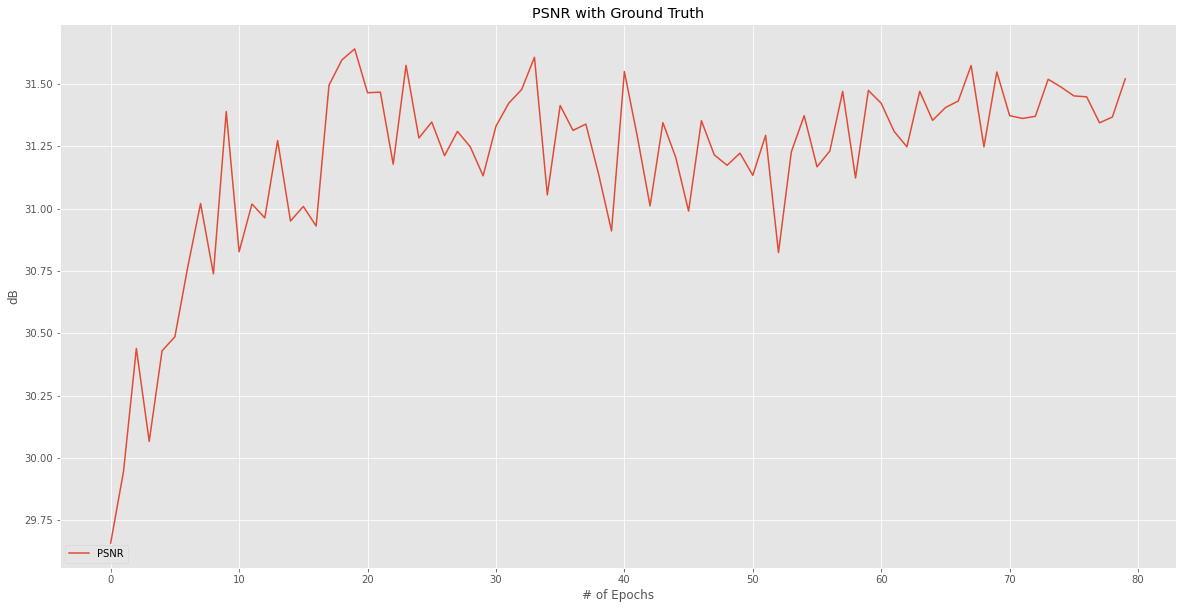

In [17]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(history['PSNR'],label='PSNR')
plt.title('PSNR with Ground Truth')
plt.xlabel('# of Epochs')
plt.ylabel('dB')
plt.legend(loc='lower left')
plt.savefig('./final_result_denoising_unet/PSNR.png')

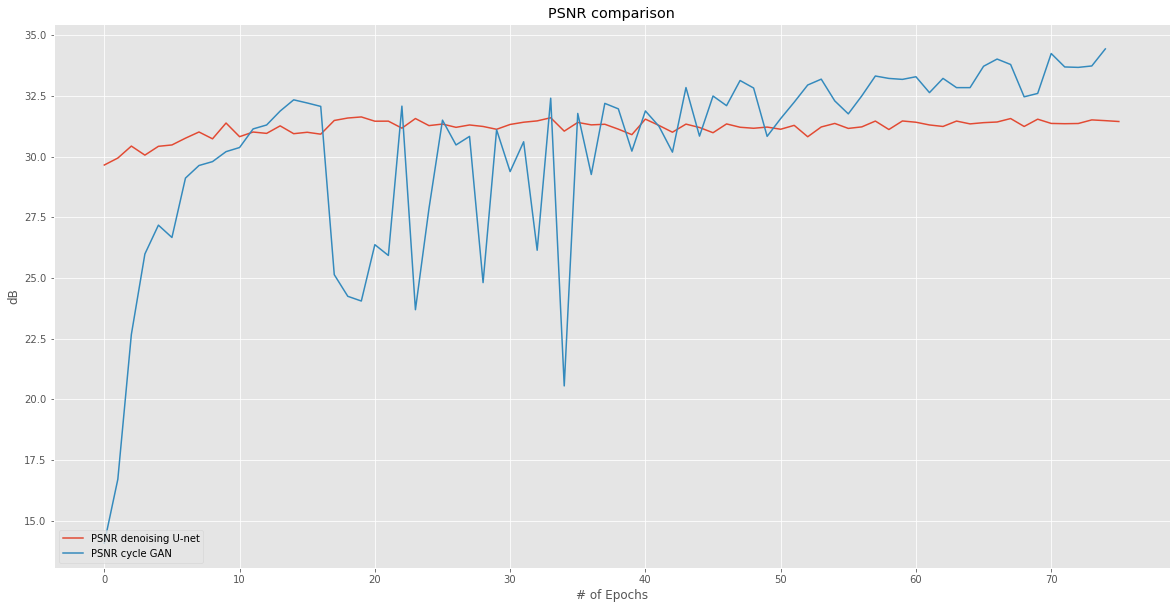

In [18]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(history['PSNR'][:76],label='PSNR denoising U-net')
plt.plot(history_cycleGan['PSNR'],label='PSNR cycle GAN')
plt.title('PSNR comparison')
plt.xlabel('# of Epochs')
plt.ylabel('dB')
plt.legend(loc='lower left')
plt.savefig('./final_result_denoising_unet/PSNR comparison.png')

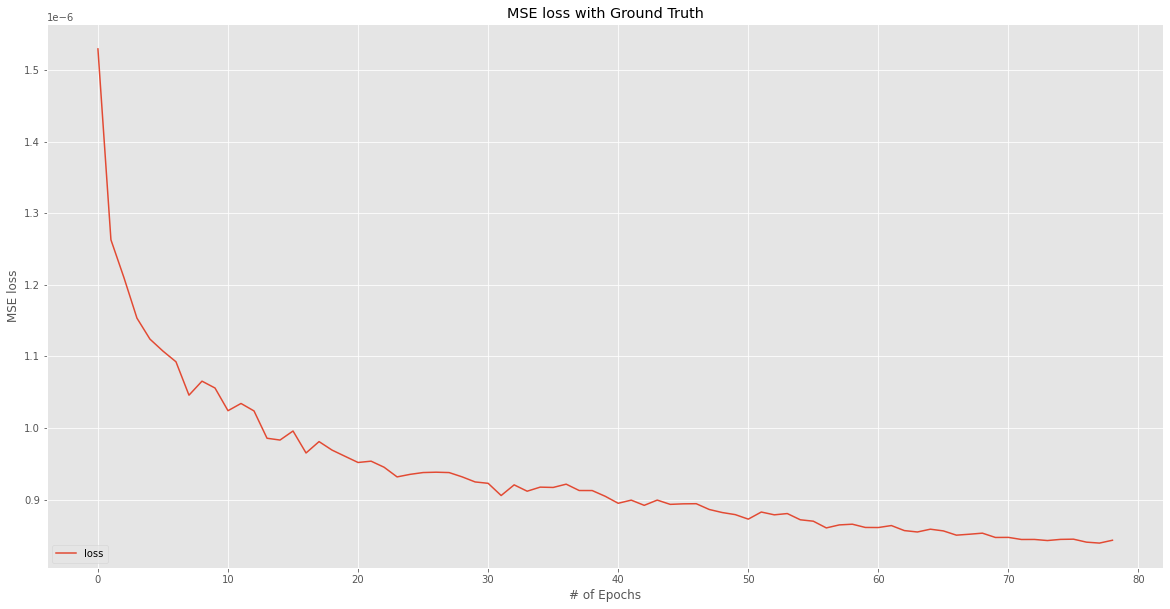

In [19]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(history['loss'][1:],label='loss')
plt.title('MSE loss with Ground Truth')
plt.xlabel('# of Epochs')
plt.ylabel('MSE loss')
plt.legend(loc='lower left')
plt.savefig('./final_result_denoising_unet/loss.png')